In [1]:
from typing import Callable, List
import numpy as np
import pandas as pd

import pyspark.sql
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count

spark = (SparkSession.builder.appName("pacdb")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", ".spark")
         .enableHiveSupport()
         .getOrCreate())

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

import matplotlib as mpl
import matplotlib.pyplot as plt

# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

24/03/19 15:32:41 WARN Utils: Your hostname, laelaps-4.local resolves to a loopback address: 127.0.0.1; using 10.138.79.221 instead (on interface en0)
24/03/19 15:32:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/19 15:32:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Data Exploration

Source - https://archive.ics.uci.edu/dataset/320/student+performance 

In [4]:
math_df = spark.read.csv("./data/student_performance/student-mat.csv", header=True, inferSchema=True, sep=";")
#portuguese_df = spark.read.csv("./data/student_performance/student-por.csv", header=True, inferSchema=True, sep=";")

## Defining the Benchmark

Reference - 
[1] Garrido, G. M., Near, J., Muhammad, A., He, W., Matzutt, R., & Matthes, F. (2021). Do I get the privacy I need? Benchmarking utility in differential privacy libraries. arXiv preprint arXiv:2109.10789.

[1] defines two attributes as sensitive - _absence_days_ and _final_exam_grade_. They also state that - 

"To set the range bounds for the sensitivity calculation, we selected values based on the domain knowledge of the real-world datasets’ attributes, e.g., for the age attribute, we selected a lower bound and an upper bound of 0 and a 100 years, respectively."

We follow the same setup.

Test Queries for PAC-DB and PipelineDP
1. Count, Sum, Mean, Var
2.  

In [5]:
from tqdm.autonotebook import tqdm
from pacdb import PACDataFrame, PACOptions, SamplerOptions, noise_to_add

### Procedure to run an experiment ###
def run_experiment(df: pyspark.sql.DataFrame,
                   query: Callable,
                   query_name: str,
                   budget_list: List[float] = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.],
                   sample_size: int = 3,
                   sampling_rate: float = 0.5,
                   m: int = 10,
                   tau: int = 1,
                   c: float = 1e-6):
    """
    Run an experiment to compare the accuracy of a query on a DataFrame with and without noise added.

    Args:
        df: PySpark DataFrame to run the query on
        query: function that takes a DataFrame and returns a numeric value
        budget_list: list of MI budgets to test
        sample_size: number of samples per MI (re-runs whole PAC algorithm sample_size times)
        sampling_rate: fraction of data to sample in PAC sampling step
        m: privacy parameter / PAC input, number of times to run PAC sampling
        tau: privacy parameter
        c: privacy parameter
    """
    
    true_answer = query(df, 1.)
    
    def create_pac_df(mi):
        """
        PACDataFrame factory function
        Includes parameters that need to be set for tests
        """
        nonlocal df, query, sampling_rate
        return (PACDataFrame.fromDataFrame(df)
                    .withOptions(PACOptions(trials = m, max_mi = mi, c = c, tau = tau))
                    .withSamplerOptions(SamplerOptions(fraction=sampling_rate))
                    .withQuery(lambda x: query(x, sampling_rate)))

    def results() -> pd.DataFrame:
        """
        Run the query on the DataFrame with and without noise added
        
        Args:
            input_df: DataFrame to run the query on, should be generated by `create_pac_df`
        """
        nonlocal sample_size # Perform `sample_size` estimations for each budget, and save results to `results` list
        nonlocal budget_list

        results: List[dict] = []  # {'mi': float, 'sampled': float, 'noised': float, 'error': float}

        for mi in tqdm(budget_list, position=0): 
            for _ in range(sample_size):
                result = {'mi': mi, 'sampled': None, 'noised': None}
                
                pac_df = create_pac_df(mi=mi)  # create PACDF with this MI

                # Subsampled but not noised release
                Xj = pac_df.sampler.sample()  # generate one sample
                Yj = pac_df._applyQuery(Xj)  # apply query directly to sample
                result['sampled'] = Yj
                
                # Full noised release
                result['noised'] = pac_df.releaseValue(quiet=True)  # perform whole PAC process and release
                
                results.append(result)

        # convert results to pandas DataFrame
        results_df = pd.DataFrame(results)
        return results_df

    def errors(results_df: pd.DataFrame) -> pd.DataFrame:
        """
        Compute the errors from a results (Pandas) DataFrame.
        """
        nonlocal budget_list, true_answer
        errors: List[dict] = []
        # for each value of MI, calculate MSE error for 'sampled' and 'noised' entries
        for mi in budget_list:
            sampled = results_df[results_df['mi'] == mi]['sampled']
            noised = results_df[results_df['mi'] == mi]['noised']
            error = {
                'mi': mi,
                'sampled': np.mean((sampled - true_answer) ** 2),
                'sampled_errorbar': np.std((sampled - true_answer) ** 2),
                'noised': np.mean((noised - true_answer) ** 2),
                'noised_errorbar': np.std((noised - true_answer) ** 2),
            }
            errors.append(error)

        errors_df = pd.DataFrame(errors)
        return errors_df

    def plot_errors(errors_df: pd.DataFrame):
        nonlocal query_name, budget_list
        fig, ax = plt.subplots(figsize=(6.4*(3/4), 4.8*(3/4)))

        plt.errorbar(errors_df['mi'], errors_df['sampled'], fmt='b.', yerr=errors_df['sampled_errorbar'], capsize=3, label='Subsampled Error')
        plt.errorbar(errors_df['mi'], errors_df['noised'], fmt='r.', yerr=errors_df['noised_errorbar'], capsize=3, label='Private Error')

        plt.xscale('log', base=2)
        budget_labels = [r'$\frac{1}{val}$'.replace("val", str(int(1/val))) if val < 1 else f'${int(val)}$' for val in budget_list]
        plt.xticks(budget_list, budget_labels)

        ax.set_axisbelow(True)
        plt.grid(True)

        plt.title(f'{query_name.title()} Accuracy')
        plt.xlabel('Mutual Information (Log Scale)')
        plt.ylabel('Error (MSE)')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"figs/{query_name.lower()}-accuracy.png")

    display(f"Experiment: {query_name}")
    display(f"The 'true answer' run directly on the whole dataset is {true_answer}")

    display(f"The results of {sample_size} trials at each MI budget are:")
    results_df = results()
    results_df.to_pickle(f"experiment_outputs/{query_name.lower()}-results.pkl")
    display(results_df)

    display(f"The computed errors of the results are:")
    errors_df = errors(results_df)
    errors_df.to_pickle(f"experiment_outputs/{query_name.lower()}-errors.pkl")
    display(errors_df)

    plot_errors(errors_df)

/var/folders/xy/7x33379123vd25mldyhv3q7m0000gn/T/ipykernel_1156/2336843472.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Count

'Experiment: count'

"The 'true answer' run directly on the whole dataset is 151.0"

'The results of 1 trials at each MI budget are:'

,mi,sampled,noised
0,0.015625,150.0,11525.873860
1,0.031250,156.0,-21180.922711
2,0.062500,166.0,2675.346254
3,0.125000,154.0,-1092.178632
4,0.250000,168.0,1582.047907
5,0.500000,128.0,2.035134
6,1.000000,154.0,387.927783
7,2.000000,140.0,58.352208
8,4.000000,162.0,86.939853


'The computed errors of the results are:'

,mi,sampled,sampled_errorbar,noised,noised_errorbar
0,0.015625,1.0,0.0,1.293878e+08,0.0
1,0.031250,25.0,0.0,4.550509e+08,0.0
2,0.062500,225.0,0.0,6.372324e+06,0.0
3,0.125000,9.0,0.0,1.545493e+06,0.0
4,0.250000,289.0,0.0,2.047898e+06,0.0
5,0.500000,529.0,0.0,2.219053e+04,0.0
6,1.000000,9.0,0.0,5.613477e+04,0.0
7,2.000000,121.0,0.0,8.583613e+03,0.0
8,4.000000,121.0,0.0,4.103702e+03,0.0


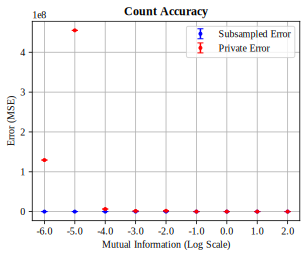

In [6]:
df = math_df.filter(math_df["absences"] >= 5)

def query(df, sampling_rate):
    return float(df.count()) * (1./sampling_rate)

run_experiment(df, query, "count", sample_size=1, sampling_rate=0.5, m=100, tau=1, c=1e-6)

## Sum

'Experiment: sum'

"The 'true answer' run directly on the whole dataset is 124.0"

'The results of 3 trials at each MI budget are:'

,mi,sampled,noised
0,0.015625,98.0,-6920.990469
1,0.015625,106.0,-65287.689542
2,0.015625,144.0,50057.746235
3,0.031250,94.0,3734.760083
4,0.031250,162.0,-4338.999761
5,0.031250,120.0,8305.786714
6,0.062500,162.0,11699.504307
7,0.062500,112.0,28714.845285
8,0.062500,106.0,-4277.088333
9,0.125000,144.0,-8490.341071


'The computed errors of the results are:'

,mi,sampled,sampled_errorbar,noised,noised_errorbar
0,0.015625,466.666667,151.237855,2.273900e+09,1.733467e+09
1,0.031250,786.666667,588.460893,3.329920e+07,2.395407e+07
2,0.062500,637.333333,575.113515,3.235994e+08,3.523169e+08
3,0.125000,166.666667,169.967317,2.723947e+07,3.321862e+07
4,0.250000,338.666667,269.643386,2.709999e+06,2.788643e+06
5,0.500000,61.333333,59.896207,3.162059e+06,2.035442e+06
6,1.000000,253.333333,156.778683,1.661213e+06,1.267478e+06
7,2.000000,258.666667,52.289791,7.749585e+04,1.689612e+04
8,4.000000,177.333333,108.730043,5.927982e+04,4.454099e+04


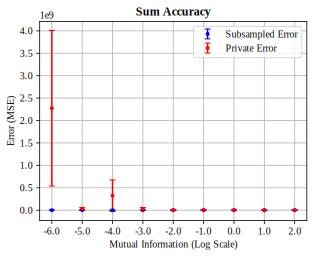

In [7]:
df = math_df

def query(df, sampling_rate):
    return float(df.filter(df["Mjob"] == "at_home").agg({"studytime": "sum"}).collect()[0][0]) * (1./sampling_rate)

run_experiment(df, query, "sum", sample_size=3, m=15, tau=1, c=1e-6)

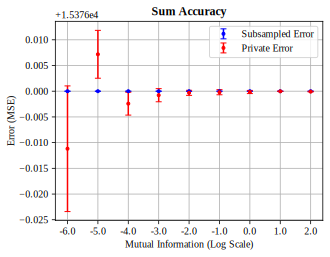

In [70]:
# Accuracy Plot
fig, ax = plt.subplots(figsize=(6.4*(3/4), 4.8*(3/4)))

plt.errorbar(errors_df['mi'], errors_df['sampled'], fmt='b.', yerr=errors_df['sampled_errorbar'], capsize=3, label='Subsampled Error')
plt.errorbar(errors_df['mi'], errors_df['noised'], fmt='r.', yerr=errors_df['noised_errorbar'], capsize=3, label='Private Error')

# error bars, y only

plt.xscale('log', base=2)
plt.xticks(budget_list, [format(np.log2(val)) for val in budget_list])

ax.set_axisbelow(True)
plt.grid(True)

plt.title('Sum Accuracy')
plt.xlabel('Mutual Information (Log Scale)')
plt.ylabel('Error (MSE)')
plt.legend()
plt.savefig("figs/sum-accuracy.png")

## Singular result

'Experiment: singular result'

"The 'true answer' run directly on the whole dataset is 1.0"

'The results of 3 trials at each MI budget are:'

  0%|          | 0/9 [00:00<?, ?it/s]

,mi,sampled,noised
0,0.015625,2.0,5.479258
1,0.015625,0.0,264.931298
2,0.015625,2.0,-53.781160
3,0.031250,0.0,121.617850
4,0.031250,0.0,6.326781
5,0.031250,0.0,43.015778
6,0.062500,0.0,31.568206
7,0.062500,2.0,-28.158850
8,0.062500,0.0,-44.840734
9,0.125000,2.0,-1.374130


'The computed errors of the results are:'

,mi,sampled,sampled_errorbar,noised,noised_errorbar
0,0.015625,1.0,0.0,24226.923162,32148.887269
1,0.031250,1.0,0.0,5447.455313,6474.476706
2,0.062500,1.0,0.0,1295.342209,570.984816
3,0.125000,1.0,0.0,87.329393,83.781366
4,0.250000,1.0,0.0,197.556171,232.174466
5,0.500000,1.0,0.0,7.551422,7.064495
6,1.000000,1.0,0.0,5.894411,3.911599
7,2.000000,1.0,0.0,0.660936,0.429705
8,4.000000,1.0,0.0,1.175222,0.638366


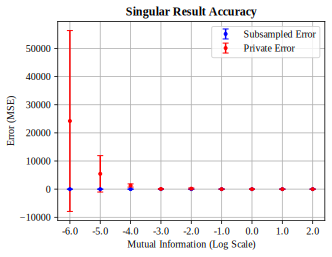

In [7]:
df = math_df

def query(df, sampling_rate):
    return df.filter((df["absences"] > 20) & (df["Mjob"] == "at_home")).count() * (1./sampling_rate)

run_experiment(df, query, "singular result", sample_size=3, m=15, tau=1, c=1e-6)

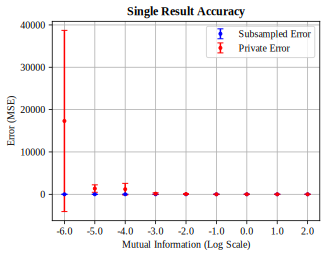

In [82]:
# Accuracy Plot
fig, ax = plt.subplots(figsize=(6.4*(3/4), 4.8*(3/4)))

plt.errorbar(errors_df['mi'], errors_df['sampled'], fmt='b.', yerr=errors_df['sampled_errorbar'], capsize=3, label='Subsampled Error')
plt.errorbar(errors_df['mi'], errors_df['noised'], fmt='r.', yerr=errors_df['noised_errorbar'], capsize=3, label='Private Error')

# error bars, y only

plt.xscale('log', base=2)
plt.xticks(budget_list, [format(np.log2(val)) for val in budget_list])

ax.set_axisbelow(True)
plt.grid(True)

plt.title('Single Result Accuracy')
plt.xlabel('Mutual Information (Log Scale)')
plt.ylabel('Error (MSE)')
plt.legend()
plt.savefig("figs/single-result-accuracy.png")

## Max

'Experiment: max'

"The 'true answer' run directly on the whole dataset is 75"

'The results of 3 trials at each MI budget are:'

  0%|          | 0/9 [00:00<?, ?it/s]

,mi,sampled,noised
0,0.015625,54,25085.181782
1,0.015625,75,91502.875554
2,0.015625,75,5624.710876
3,0.031250,75,-15381.984613
4,0.031250,40,2508.689299
5,0.031250,25,-13974.795432
6,0.062500,75,-3957.276738
7,0.062500,75,-6112.042517
8,0.062500,54,9859.380593
9,0.125000,56,136.043076


'The computed errors of the results are:'

,mi,sampled,sampled_errorbar,noised,noised_errorbar
0,0.015625,147.000000,207.889394,3.005122e+09,3.793581e+09
1,0.031250,1241.666667,1020.688765,1.474127e+08,1.014743e+08
2,0.062500,147.000000,207.889394,5.009095e+07,3.350319e+07
3,0.125000,576.666667,579.323935,5.015843e+06,7.000274e+06
4,0.250000,942.333333,766.257282,3.492930e+06,2.932466e+06
5,0.500000,120.333333,170.177032,7.426204e+05,5.300829e+05
6,1.000000,240.666667,170.177032,5.368143e+05,4.148212e+05
7,2.000000,294.000000,207.889394,8.320772e+03,5.885758e+03
8,4.000000,267.333333,191.833840,2.049132e+03,1.605128e+03


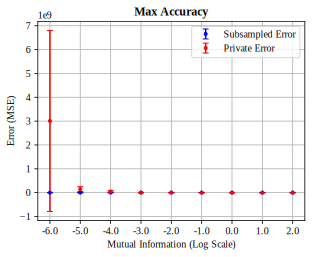

In [8]:
df = math_df

def query(df, sampling_rate):
    return df.agg({"absences": "max"}).collect()[0][0]

run_experiment(df, query, "max", sample_size=3, m=15, tau=1, c=1e-6)

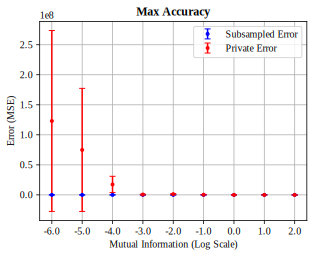

In [106]:
# Accuracy Plot
fig, ax = plt.subplots(figsize=(6.4*(3/4), 4.8*(3/4)))

plt.errorbar(errors_df['mi'], errors_df['sampled'], fmt='b.', yerr=errors_df['sampled_errorbar'], capsize=3, label='Subsampled Error')
plt.errorbar(errors_df['mi'], errors_df['noised'], fmt='r.', yerr=errors_df['noised_errorbar'], capsize=3, label='Private Error')

# error bars, y only

plt.xscale('log', base=2)
plt.xticks(budget_list, [format(np.log2(val)) for val in budget_list])

ax.set_axisbelow(True)
plt.grid(True)

plt.title('Max Accuracy')
plt.xlabel('Mutual Information (Log Scale)')
plt.ylabel('Error (MSE)')
plt.legend()
plt.savefig("figs/max-accuracy.png")

## Aggregate Stats in case of skewed distribution

'Experiment: count aggregation on skewed data'

"The 'true answer' run directly on the whole dataset is 90.0"

'The results of 3 trials at each MI budget are:'

  0%|          | 0/9 [00:00<?, ?it/s]

,mi,sampled,noised
0,0.015625,86.0,2992.729207
1,0.015625,88.0,-4631.623305
2,0.015625,80.0,-23243.919604
3,0.031250,94.0,4408.889134
4,0.031250,86.0,4216.861249
5,0.031250,114.0,3720.840032
6,0.062500,86.0,833.487025
7,0.062500,80.0,688.974882
8,0.062500,100.0,826.880008
9,0.125000,90.0,-403.660460


'The computed errors of the results are:'

,mi,sampled,sampled_errorbar,noised,noised_errorbar
0,0.015625,40.000000,42.708313,1.917305e+08,2.494900e+08
1,0.031250,202.666667,263.986532,1.628893e+07,2.293857e+06
2,0.062500,72.000000,39.597980,4.848453e+05,8.923746e+04
3,0.125000,5.333333,7.542472,1.596199e+06,1.104433e+06
4,0.250000,22.666667,9.428090,3.367691e+05,3.105778e+05
5,0.500000,118.666667,75.636558,1.219892e+05,1.353080e+05
6,1.000000,24.000000,28.284271,5.525103e+03,6.131998e+03
7,2.000000,60.000000,61.188234,3.299928e+03,4.264938e+03
8,4.000000,193.333333,152.641919,2.225295e+03,2.171385e+03


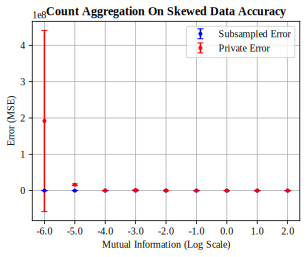

In [11]:
df = math_df

def query(df, sampling_rate):
    return float(df.filter(col("guardian") == "father").count()) * (1./sampling_rate)

run_experiment(df, query, "count aggregation on skewed data", sample_size=3, m=15, tau=1, c=1e-6)

## Multiple Predicates - Apply first

'Experiment: multiple predicates, apply first'

"The 'true answer' run directly on the whole dataset is 8.0"

'The results of 3 trials at each MI budget are:'

  0%|          | 0/9 [00:00<?, ?it/s]

,mi,sampled,noised
0,0.015625,8.0,1059.774122
1,0.015625,4.0,-2494.396298
2,0.015625,10.0,-2616.020083
3,0.031250,0.0,-523.802203
4,0.031250,14.0,205.410460
5,0.031250,4.0,-294.058597
6,0.062500,6.0,138.988433
7,0.062500,12.0,-120.516331
8,0.062500,6.0,-224.424568
9,0.125000,8.0,-73.777468


'The computed errors of the results are:'

,mi,sampled,sampled_errorbar,noised,noised_errorbar
0,0.015625,6.666667,6.798693,4.751232e+06,2.589945e+06
1,0.031250,38.666667,19.686431,1.376746e+05,1.048236e+05
2,0.062500,8.000000,5.656854,2.923187e+04,1.753065e+04
3,0.125000,0.000000,0.000000,3.270217e+03,2.715791e+03
4,0.250000,13.333333,16.110728,6.500678e+03,4.368100e+03
5,0.500000,18.666667,13.199327,1.058951e+02,1.341077e+02
6,1.000000,26.666667,27.194771,8.453300e+02,1.080352e+03
7,2.000000,14.666667,15.084945,2.621443e+00,1.752803e+00
8,4.000000,6.666667,6.798693,4.224761e+00,5.870526e+00


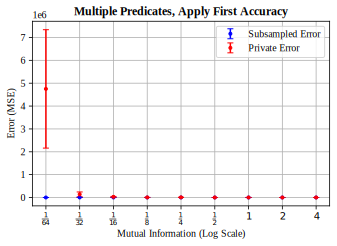

In [6]:
df = math_df

def query(df, sampling_rate):
    return float(df.filter((df["absences"] > 10) & (df["Mjob"] == "at_home")).count()) * (1./sampling_rate)

run_experiment(df, query, "multiple predicates, apply first", sample_size=3, m=15, tau=1, c=1e-6)

## Multiple Predicates - Apply 1 filter, sample, then apply next filter

'Experiment: multiple predicates: filter, sample, filter'

"The 'true answer' run directly on the whole dataset is 8.0"

'The results of 3 trials at each MI budget are:'

  0%|          | 0/9 [00:00<?, ?it/s]

,mi,sampled,noised
0,0.015625,8.0,805.287932
1,0.015625,10.0,737.154545
2,0.015625,10.0,-562.370715
3,0.031250,6.0,-1463.216873
4,0.031250,10.0,1005.637979
5,0.031250,10.0,-47.686444
6,0.062500,8.0,-110.728276
7,0.062500,4.0,-116.289931
8,0.062500,10.0,372.595517
9,0.125000,12.0,12.719894


'The computed errors of the results are:'

,mi,sampled,sampled_errorbar,noised,noised_errorbar
0,0.015625,2.666667,1.885618,4.975524e+05,128973.828182
1,0.031250,4.000000,0.000000,1.054287e+06,883364.810166
2,0.062500,6.666667,6.798693,5.415809e+04,55702.804839
3,0.125000,12.000000,5.656854,1.588139e+04,13519.656775
4,0.250000,13.333333,16.110728,3.700488e+03,4962.376818
5,0.500000,12.000000,5.656854,8.857906e+02,455.166136
6,1.000000,12.000000,5.656854,3.260209e+02,410.014685
7,2.000000,1.333333,1.885618,3.276440e+01,21.561841
8,4.000000,10.666667,7.542472,2.866710e+01,27.387231


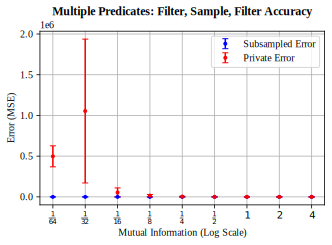

In [7]:
df = math_df.filter((math_df["absences"] > 10))

def query(df, sampling_rate):
    return float(df.filter((df["Mjob"] == "at_home")).count()) * (1./sampling_rate)

run_experiment(df, query, "multiple predicates: filter, sample, filter", sample_size=3, m=15, tau=1, c=1e-6)

## Mean

PAC-count / PAC-sum vs PAC-mean

## Var

σ^2=n∑i=1 ​(xi​−x)^2 / n 

(Chorus does not implement variance---find out why?)​